# Klasyfikacja tekstów sieciami neuronowymi

Ten plik umożliwa testowanie klasyfikatorów na pojednyczym zbiorze danych i tworzenie własnych zbiorów.

###Działania przygotowawcze: podłączenie Dysku Google, instalacja wymaganych pakietów, dołączenie katalogu projektu do ścieżki systemowej i import potrzebnych klas z projektu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# ścieżka do bieżącego katalogu (należy edytować, jeśli się nie zgadza)
%cd gdrive/MyDrive/praca_inzynierska/authorship_analysis_project/training_models

In [ ]:
! pip install -r ../requrements.txt
! python -m spacy download pl_core_news_lg

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
print(sys.path)

In [ ]:
import numpy as np

from data_preparation import CorpusPreparation
from pipelines import Pipeline, Explain
from data_fetchers import EpochsFetcher, BookSet

###Określenie listy autorów i wczytanie listy tytułów tekstów

Komentarze:
- Wśród autorów pojawia się Daniel Naborowski, jednak jego zbór tekstów jest tak ubogi, że zostaje pominięty (nie jest uwzgędniony w tekście pracy).
- Ten fragment kodu wymaga podłączenia do internetu, bo lista ksiażek jest ściągana z Wolnych Lektur.

In [5]:
bookset = BookSet()
bookset.fetch()
kinds = ['Epika']
if kinds[0]=='Epika':
  authors = ['Eliza Orzeszkowa', 'Henryk Sienkiewicz', 'Bolesław Prus']
  books_list = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors, kinds))
  books_epoch_list = [books_list]
if kinds[0]=='Liryka':
  authors = ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
  authors_b = ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka']
  authors_r = ['Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid']
  authors_p = ['Adam Asnyk', 'Maria Konopnicka']
  authors_m = ['Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
  books_list_b = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_b, kinds))
  books_list_r = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_r, kinds))
  books_list_p = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_p, kinds))
  books_list_m = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_m, kinds))
  books_epoch_list = [books_list_b, books_list_r, books_list_p, books_list_m]
print(books_epoch_list)

[[('Bolesław Prus', 'Antek'), ('Eliza Orzeszkowa', 'Australczyk'), ('Eliza Orzeszkowa', 'Autobiografia w listach'), ('Henryk Sienkiewicz', 'Bartek zwycięzca'), ('Henryk Sienkiewicz', 'Bez dogmatu'), ('Eliza Orzeszkowa', 'Cicho, cicho na leśnej polanie...'), ('Eliza Orzeszkowa', 'Cnotliwi'), ('Eliza Orzeszkowa', 'Co mówił stary klon?'), ('Eliza Orzeszkowa', 'Czy pamiętasz?'), ('Eliza Orzeszkowa', 'Dobra pani'), ('Eliza Orzeszkowa', 'Dwa bieguny'), ('Eliza Orzeszkowa', 'Dymy'), ('Eliza Orzeszkowa', 'Dziurdziowie'), ('Eliza Orzeszkowa', 'Šunadvokatis'), ('Bolesław Prus', 'Emancypantki'), ('Bolesław Prus', 'Emancypantki, tom pierwszy'), ('Bolesław Prus', 'Emancypantki, tom drugi'), ('Bolesław Prus', 'Faraon'), ('Bolesław Prus', 'Faraon, tom drugi'), ('Bolesław Prus', 'Faraon, tom pierwszy'), ('Bolesław Prus', 'Faraon, tom trzeci'), ('Eliza Orzeszkowa', 'Gdzie szczęście?'), ('Eliza Orzeszkowa', 'Gedali'), ('Eliza Orzeszkowa', 'Bóg wie kto'), ('Eliza Orzeszkowa', 'Dziwna historia'), ('Eliza 

###Zbiory treningowe i testowe

> Uwaga: zbiór treningowy zostaje później podzielony na zbiór walidacyjny i zbór treningowy właściwy



Lista dostępnych zbiorów zapisanych jako pickle. Zbiory oznaczone są liczbami naturalnymi i cyfra dziesiątek oznacza sposób podziału zbioru na zbiory testowe i uczące z określoną liczbą słów w próbce, a cyfra jednosci oznacza wybrany preprocessing.

In [6]:
from os.path import exists
import pickle
datasets_filepath = 'datasets/features_'
for i in range(100):
  path = datasets_filepath + str(i)
  if exists(path):
    print(path)
    with open(path, 'rb') as f:
      data = pickle.load(f)
      head_data, _, _, _, _ = data
      print(f'test_size: {head_data[0]}, train_size: {head_data[1]}, number of words in paragraph: {head_data[2]}, preprocessing operations: {head_data[3]}, authors: {head_data[4]}')

datasets/features_0
test_size: 20, train_size: 100, number of words in paragraph: 15, preprocessing operations: ['anonymize'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
datasets/features_1
test_size: 20, train_size: 100, number of words in paragraph: 15, preprocessing operations: ['anonymize', 'lower_text', 'remove_stop_words'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
datasets/features_2
test_size: 20, train_size: 100, number of words in paragraph: 15, preprocessing operations: ['anonymize'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz'

In [7]:
read_from_frozen_dataset = False # wybór zamrożonych datasetów z określonym preprocessingiem, ale podział definiuje się samodzielnie
use_prepared_dataset = True # wybór skorzystania ze zbioru z określonym podziałem i preprocessingiem
number_of_dataset = 70 # numer wybranego zbioru zapisanego jako pickle
save_dataset = False # zbiór można zapisać jako kolejny pickle
save_number = 0 #numer najlepiej wybrac spoza wykorzystanych numerów, bo się nadpisze

mixed = False # określenie, czy książki ze zbioru treningowego mogą być też w zbiorze testowym
test_size = 200 #liczba próbek
train_size = 1000 #liczba próbek
words_num_in_par = 300 #liczba słów w próbce
representations = ['bow'] # 'bow'/ 'wp'/ 'emb'
models = ['nn']
preprocessing_list = ['anonymize']
prep_descr = 'a' # 'a' / 'alo' / 'alp' / 'als' / 'alomp_NVAdj' # skrót do nazw pliku
kinds_descr = 'e' # 'e' / 'l' # skrót do nazw pliku

In [8]:
if use_prepared_dataset:
  file_name_read = datasets_filepath + str(number_of_dataset)
  with open(file_name_read, 'rb') as f:
    data = pickle.load(f)
    head_data, train_set, train_classes, test_set, test_classes = data
    test_size, train_size, words_num_in_par, preprocessing_list, authors = head_data
elif read_from_frozen_dataset:
  cp = CorpusPreparation()
  cp.read_corpus_form_frozen_dataset(authors, prep_descr, kinds_descr)
  cp.split_books(words_num_in_par)
  if mixed:
      train_set, train_classes, test_set, test_classes = cp.prepare_corpus_mixed_books(train_size, test_size)
  else:
      train_set, train_classes, test_set, test_classes = cp.prepare_corpus_divide_books(train_size, test_size)
else:
  cp = CorpusPreparation(books_epoch_list)
  cp.get_books()
  cp.books_preprocessing(preprocessing_list)
  cp.split_books(words_num_in_par)
  if mixed:
      train_set, train_classes, test_set, test_classes = cp.prepare_corpus_mixed_books(train_size, test_size)
  else:
      train_set, train_classes, test_set, test_classes = cp.prepare_corpus_divide_books(train_size, test_size)
print(f'test_size: {test_size}, train_size: {train_size}, number of words in paragraph: {words_num_in_par}, preprocessing operations: {preprocessing_list}, authors: {authors}')

test_size: 120, train_size: 300, number of words in paragraph: 1000, preprocessing operations: ['anonymize'], authors: ['Eliza Orzeszkowa', 'Henryk Sienkiewicz', 'Bolesław Prus']


In [9]:
if save_dataset:
  file_name_save = datasets_filepath + str(save_number)
  with open(file_name_save, 'wb') as f:
    head_data = [test_size, train_size, words_num_in_par, preprocessing_list, authors]
    data = [head_data, train_set, train_classes, test_set, test_classes]
    pickle.dump(data, f)

Lista autorów istniejących w zbiorach treningowym i testowym

In [10]:
existing_authors_set = set(train_classes)
authors_max_books = {}
authors = []
for books_epoch in books_epoch_list:
    authors_list = [author for (author, title) in books_epoch]
    authors_set = sorted(list(set(authors_list)))
    for author in authors_set:
        if author in existing_authors_set:
            books_num = authors_list.count(author)
            if author in authors:
                if books_num > authors_max_books[author]:
                    authors.remove(author)
                    authors_max_books[author] = books_num
                    authors.append(author)
            else:
                authors.append(author)
                authors_max_books[author] = books_num
authors


['Bolesław Prus', 'Eliza Orzeszkowa', 'Henryk Sienkiewicz']

### Definiowanie argumentów sieci

Uwaga: część argumentów (na przykład dotyczących embeddingu) można zmienić w kodzie projektu w plikach ../data_representation/reprezentation.py i ../models/neural_net.py

In [11]:
select_k_wp = 10000
select_k_bow = 8000
epochs_bow = 64
epochs_wp = 16
batch_size = 64
layer_units = 16
layers_arch = 'basic' # 'basic', 'lstm', 'embed_basic', 'embed_glove_lstm'

ann_args_bow = [select_k_bow, epochs_bow, batch_size, layer_units, layers_arch]
ann_args_wp = [select_k_wp, epochs_wp, batch_size, layer_units, layers_arch]

ann_args_dict = {
   (representations[0], models[0]): ann_args_bow
    #(representations[1], models[0]): ann_args_wp
}

### Testy klasyfikatorów

<class 'numpy.ndarray'>
(900, 8000)
<class 'numpy.ndarray'>
(180, 8000) (180, 3)
(720, 8000) (720, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128016    
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 128,067
Trainable params: 128,067
Non-trainable params: 0
_________________________________________________________________
None
12/12 [==============================] - 0s 3ms/step


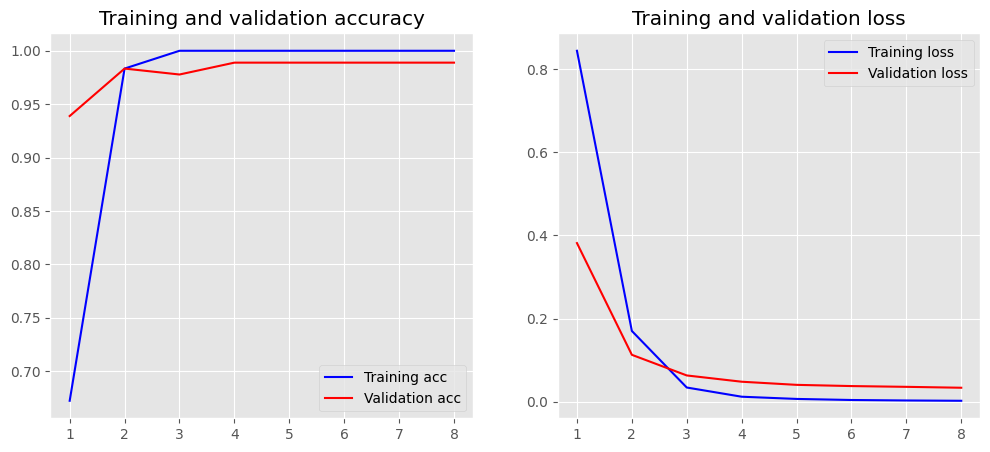

In [12]:
p = Pipeline(
    corpus_train=train_set,
    corpus_test=test_set,
    classes_train=train_classes,
    classes_test=test_classes,
    class_names=authors,
    representations=representations,
    models=models,
    ann_args_dict=ann_args_dict)
p.pipelines()

In [13]:
p.print_accuracy()

   method  accuracy
0  bow+nn  0.991667


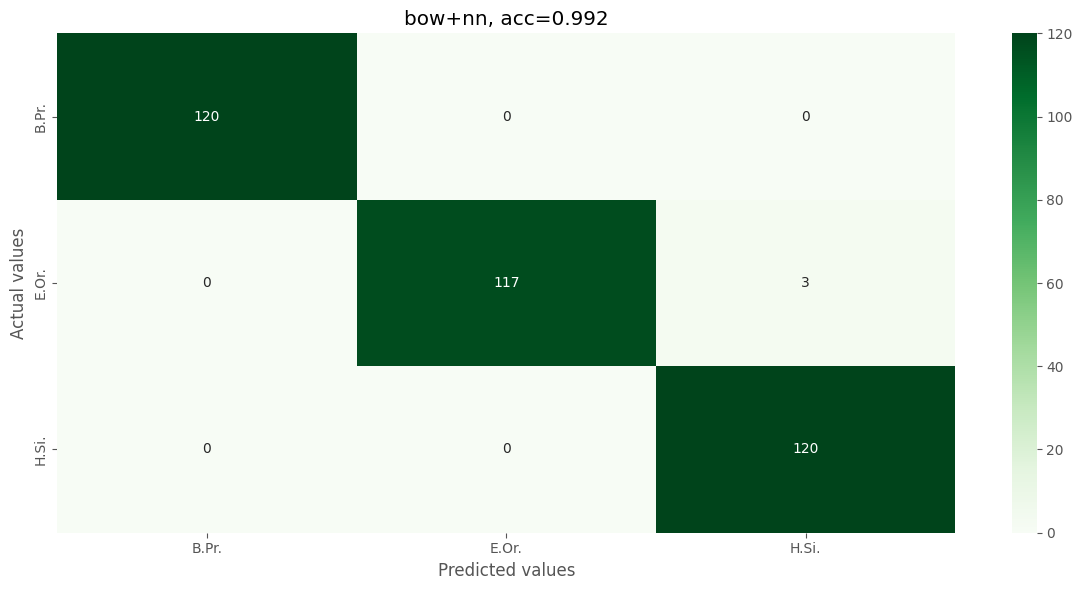

In [14]:
p.print_confussion_matrix()

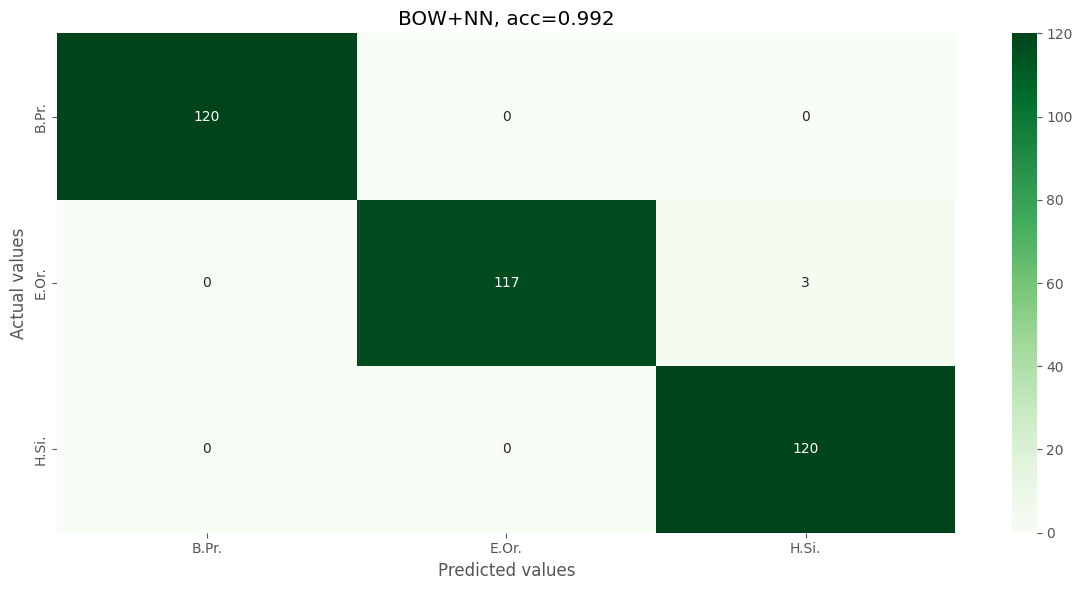

In [15]:
d = ''
if not mixed:
    d = '_div'
path = f'../figures/neural_nets_fig{train_size}_{test_size}_{words_num_in_par}{d}_{prep_descr}_{kinds_descr}.jpg'
p.save_img(path)

### Możliwy rozwój projektu - wyjaśnialność klasyfikatorów sieci neuronowych

In [16]:
expl = Explain(p)

In [17]:
true_author = 'Henryk Sienkiewicz'
#true_author = 'Adam Mickiewicz'
#true_author = 'Juliusz Słowacki'
if true_author == 'Henryk Sienkiewicz':
  lime_text_path = './text_examples/sienkiewicz.txt'
if true_author == 'Adam Mickiewicz':
  lime_text_path = './text_examples/mickiewicz.txt'
if true_author == 'Juliusz Słowacki':
  lime_text_path = './text_examples/slowacki.txt'
with open(lime_text_path, encoding='utf-8') as f:
  text = f.read()
print(len(text.split()))

703


In [18]:
print(expl.classify(text, 0))

1/1 [==============================] - 0s 20ms/step
nn   bow :  ['Henryk Sienkiewicz']
['Eliza Orzeszkowa', 'Henryk Sienkiewicz', 'Bolesław Prus']
[[0.09280481]
 [0.82150218]
 [0.08569301]]

['Henryk Sienkiewicz']


In [ ]:
expl.lime(text, 0, 'lime_whatever.jpg', true_author)

In [ ]:
expl.shap(text, 0)
